# GAN Model

### Libraries and Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np

# Competion Requirements
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

C:\Users\kbk27\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Number of replicas: 1
2.11.0


### Dataset

#### Path Details

In [2]:
# GCS_PATH = KaggleDatasets().get_gcs_path()
GCS_PATH = "../Data"

In [3]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


#### Helper Functions for Loading

In [4]:
# Image size in the Dataset are predefined by the competition
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [5]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

#### Loading Dataset

In [6]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

#### Sample Data Display

In [7]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

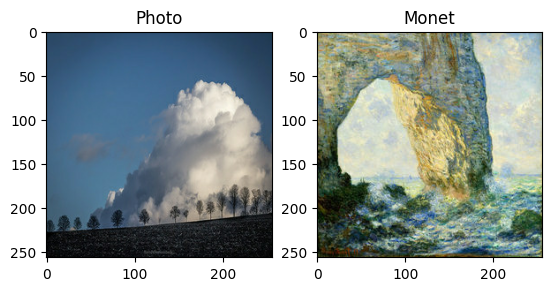

In [8]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

### Model

#### Discriminator

In [9]:
def discriminator_model(input_shape=(256,256,3)):
    model = tf.keras.models.Sequential([
        keras.Input(input_shape),
        layers.Conv2D(64, padding='same', strides=(2,2), kernel_size=(4, 4), activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed=None)),
        layers.Conv2D(128, padding='same', strides=(2,2), kernel_size=(4, 4), activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed=None)),
        layers.Conv2D(256, padding='same', strides=(2,2), kernel_size=(4, 4), activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed=None)),
        layers.Conv2D(512, padding='same', strides=(1,1), kernel_size=(4, 4), activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed=None)),
        layers.Conv2D(1, padding='same', strides=(1,1), kernel_size=(4, 4), activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed=None)),
    ])

    return model

In [33]:
monet_discriminator = discriminator_model()
photo_discriminator = discriminator_model()

In [11]:
monet_discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       524544    
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 512)       2097664   
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 1)         8193      
                                                                 
Total params: 2,764,737
Trainable params: 2,764,737
Non-trainable params: 0
_________________________________________________________________


#### Generator

In [12]:
def generator_model(input_shape=(256,256,3)):
    model = tf.keras.models.Sequential([
        keras.Input(input_shape),
        layers.Conv2D(64, padding='same', strides=(1,1), kernel_size=(7, 7), activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed=None)),
        layers.Conv2D(128, padding='same', strides=(2,2), kernel_size=(3, 3), activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed=None)),
        layers.Conv2D(256, padding='same', strides=(2,2), kernel_size=(3, 3), activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed=None)),
        layers.Conv2DTranspose(128, padding='same', strides=(2,2), kernel_size=(3, 3), activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed=None)),
        layers.Conv2DTranspose(64, padding='same', strides=(2,2), kernel_size=(3, 3), activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed=None)),
        layers.Conv2DTranspose(3, padding='same', strides=(1,1), kernel_size=(7, 7), activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed=None)),
    ])

    return model

In [32]:
monet_generator = generator_model()
photo_generator = generator_model()

In [14]:
monet_generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 256, 256, 64)      9472      
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 256)       295168    
                                                                 
 conv2d_transpose (Conv2DTra  (None, 128, 128, 128)    295040    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 256, 256, 64)     73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 256, 256, 3)     

### Loss Functions

#### Monet

In [15]:
def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [16]:
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [17]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [18]:
def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

### Cycle GAN

In [19]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Training

In [34]:
monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [35]:
cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

In [36]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 429s 1s/step - monet_gen_loss: 10.4168 - photo_gen_loss: 11.0427 - monet_disc_loss: 0.4159 - photo_disc_loss: 0.3863
Epoch 2/25
300/300 [==============================] - 417s 1s/step - monet_gen_loss: 8.5630 - photo_gen_loss: 9.2638 - monet_disc_loss: 0.4640 - photo_disc_loss: 0.3894
Epoch 3/25
300/300 [==============================] - 416s 1s/step - monet_gen_loss: 8.3126 - photo_gen_loss: 9.0327 - monet_disc_loss: 0.4679 - photo_disc_loss: 0.3918
Epoch 4/25
300/300 [==============================] - 415s 1s/step - monet_gen_loss: 8.1965 - photo_gen_loss: 8.9199 - monet_disc_loss: 0.4454 - photo_disc_loss: 0.3843
Epoch 5/25
300/300 [==============================] - 410s 1s/step - monet_gen_loss: 8.1384 - photo_gen_loss: 8.8663 - monet_disc_loss: 0.5993 - photo_disc_loss: 0.3766
Epoch 6/25
300/300 [==============================] - 408s 1s/step - monet_gen_loss: 8.0756 - photo_gen_loss: 8.8029 - monet_disc_loss: 0.6930 - photo_di

### Visualize

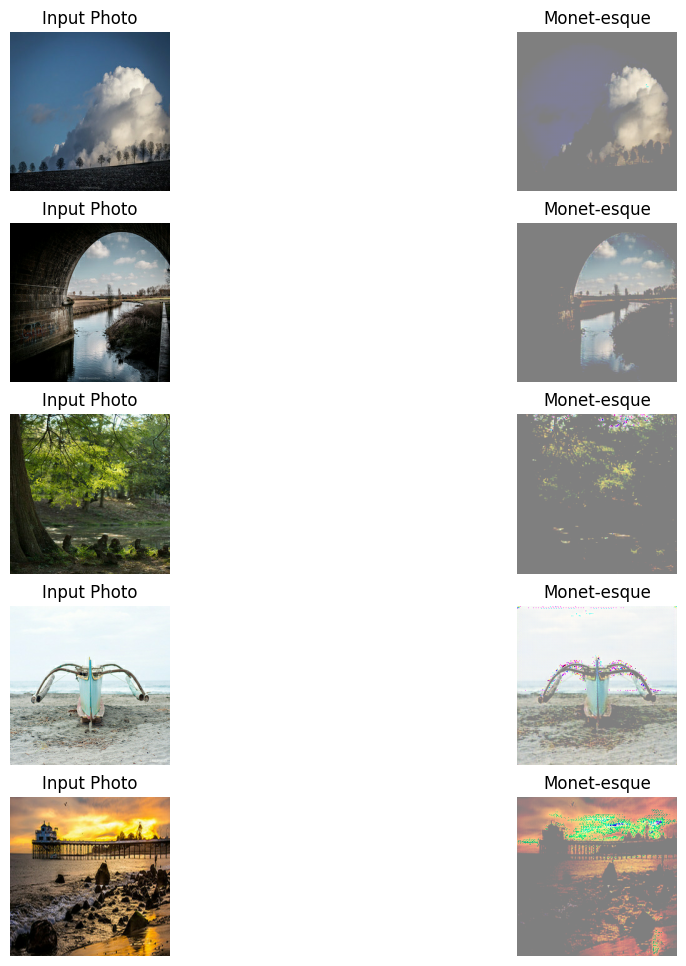

In [37]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Saving the Model

In [38]:
monet_generator.save('GeneratorModel')

INFO:tensorflow:Assets written to: GeneratorModel\assets


INFO:tensorflow:Assets written to: GeneratorModel\assets


### Loading the Model

In [39]:
model = keras.models.load_model('GeneratorModel')

In [41]:
model.compile()

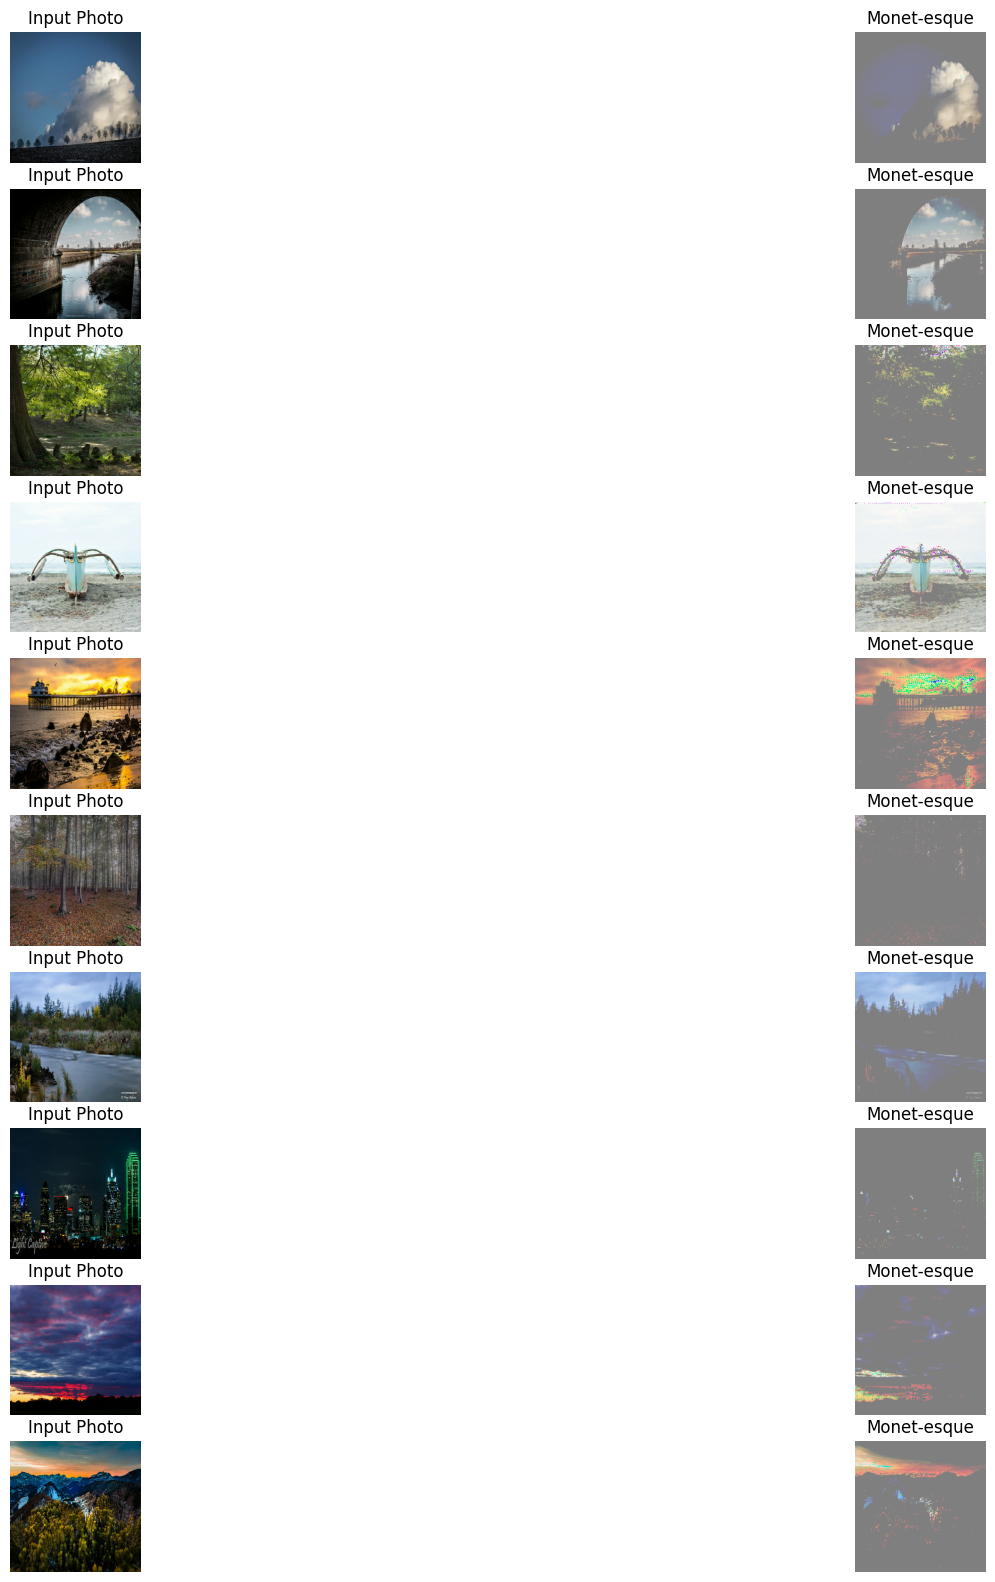

In [43]:
_, ax = plt.subplots(10, 2, figsize=(20, 20))
for i, img in enumerate(photo_ds.take(10)):
    prediction = model(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()